In [4]:
pip install opencv-python numpy tqdm

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.6/39.5 MB 9.4 MB/s eta 0:00:05
   --- ------------------------------------ 3.4/39.5 MB 8.4 MB/s eta 0:00:05
   ----- ---------------------------------- 5.2/39.5 MB 8.4 MB/s eta 0:00:05
   ------ --------------------------------- 6.8/39.5 MB 8.4 MB/s eta 0:00:04
   -------- ------------------------------- 8.7/39.5 MB 8.4 MB/s eta 0:00:04
   ---------- ----------------------------- 10.5/39.5 MB 8.4 MB/s eta 0:00:04
   ------------ --------------------------- 12.1/39.5 MB 8.4 MB/s eta 0:00:04
   -------------- ------------------------- 13.9/39.5 MB 8.4 MB/s eta 0:00:04
   --------------- ------------------------ 15.7/39.5 MB 8.4 MB/s eta 0:00:03
   ----------------- ---------------------- 17.6/39.5 MB 8.4 MB/s eta 0:00:03
   ------------------- -------------------- 19.4/39.5 MB 8.3 MB/s eta 0:00:03
   --------------------- ------------------ 21.2/39.5 MB 8.4 MB/s eta 0:00:03

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random

# CONFIG
SOURCE_DIR = r"D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\Test"       # Replace with your actual path
DEST_DIR = r"D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data"       # Output folder
TARGET_COUNT = 700
IMG_SIZE = (224, 224)

os.makedirs(DEST_DIR, exist_ok=True)

# Augmentation functions
def augment_image(img):
    methods = [
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.rotate(x, cv2.ROTATE_180),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE)
    ]
    return random.choice(methods)(img)

# Data holders
all_labels = []

# Process each class folder
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"\nProcessing class: {class_name}")
    images = []

    # Load and resize images
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        try:
            img = cv2.imread(file_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)

            # Ensure 3-channel RGB
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] > 3:
                img = img[:, :, :3]

            images.append(img)
            if len(images) == TARGET_COUNT:
                break
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

    # Augment if fewer than 700
    if len(images) < TARGET_COUNT:
        print(f"Only {len(images)} found, augmenting to reach 700...")
        i = 0
        while len(images) < TARGET_COUNT:
            augmented = augment_image(images[i % len(images)])
            images.append(augmented)
            i += 1

    # Convert to numpy array
    images_array = np.array(images, dtype=np.uint8)
    save_path = os.path.join(DEST_DIR, f"{class_name}.npy")
    np.save(save_path, images_array)
    print(f"Saved: {save_path} | Shape: {images_array.shape}")

    # Add labels
    all_labels.extend([class_name] * TARGET_COUNT)

# Save labels
labels_path = os.path.join(DEST_DIR, 'labels.npy')
np.save(labels_path, np.array(all_labels))
print(f"\n✅ Labels saved to {labels_path} | Total labels: {len(all_labels)}")



Processing class: freshapples
Saved: D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data\freshapples.npy | Shape: (700, 224, 224, 3)

Processing class: freshbanana
Saved: D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data\freshbanana.npy | Shape: (700, 224, 224, 3)

Processing class: freshbellpepper
Only 611 found, augmenting to reach 700...
Saved: D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data\freshbellpepper.npy | Shape: (700, 224, 224, 3)

Processing class: freshbittergroud
Only 327 found, augmenting to reach 700...
Saved: D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data\freshbittergroud.npy | Shape: (700, 224, 224, 3)

Processing class: freshcapsicum
Saved: D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data\freshcapsicum.npy | Shape: (700, 224, 224, 3)

Processing class: freshcarrot
Only 620 found, 

In [2]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# CONFIG
DATA_DIR = r"D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\train_700_data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# 1. Load labels
labels = np.load(os.path.join(DATA_DIR, 'labels.npy'))

# 2. Load all image data from .npy files
image_list = []
label_list = []

for file in os.listdir(DATA_DIR):
    if file.endswith('.npy') and file != 'labels.npy':
        img_array = np.load(os.path.join(DATA_DIR, file))
        image_list.append(img_array)

# Combine all images into one array
all_images = np.concatenate(image_list, axis=0)  # shape: (total_samples, 224, 224, 3)
print("All images shape:", all_images.shape)

# Normalize and prepare as tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1]
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# Apply transforms
transformed_images = torch.stack([transform(img) for img in all_images])
print("Transformed tensor shape:", transformed_images.shape)

# DataLoader
dataset = TensorDataset(transformed_images)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Load Pretrained Models (remove classification layer)
def get_feature_model(base_model, layer_name):
    model = base_model
    model.eval()
    model.to(DEVICE)
    if layer_name == 'avgpool':  # for GoogLeNet, ResNeXt101
        return torch.nn.Sequential(*(list(model.children())[:-1]))
    elif layer_name == 'features':  # for DenseNet
        return model.features
    return model

googlenet = get_feature_model(models.googlenet(pretrained=True), 'avgpool')
resnext = get_feature_model(models.resnext101_32x8d(pretrained=True), 'avgpool')
densenet = get_feature_model(models.densenet201(pretrained=True), 'features')

# 4. Extract features from all three models
def extract_features(model, inputs, model_type):
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        feats = model(inputs)
        if model_type == 'densenet':
            feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1))
        return feats.view(inputs.size(0), -1).cpu()

all_features = []

for batch in tqdm(dataloader, desc="Extracting features"):
    x = batch[0]

    f1 = extract_features(googlenet, x, 'googlenet')     # shape: [B, 1024]
    f2 = extract_features(resnext, x, 'resnext')         # shape: [B, 2048]
    f3 = extract_features(densenet, x, 'densenet')       # shape: [B, 1920]

    combined = torch.cat([f1, f2, f3], dim=1)            # shape: [B, 1024+2048+1920=4992]
    all_features.append(combined)

# Combine all batches
final_features = torch.cat(all_features, dim=0).numpy()
print("Final feature shape:", final_features.shape)  # should be (total_samples, 4992)

# Save
np.save('combined_features.npy', final_features)
np.save('combined_labels.npy', labels)
print("\n✅ Saved features and labels!")


All images shape: (18200, 224, 224, 3)
Transformed tensor shape: torch.Size([18200, 3, 224, 224])


c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\ok/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:07<00:00, 7.16MB/s]
c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depreca

Final feature shape: (18200, 4992)

✅ Saved features and labels!


In [4]:
pip install scikit-learn

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ------ --------------------------------- 1.8/10.7 MB 8.4 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/10.7 MB 8.4 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/10.7 MB 8.4 MB/s eta 0:00:01
   -------------------------- ------------- 7.1/10.7 MB 8.4 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.7 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------  10.5/10.7 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/41.0 MB 8.4 MB/s eta 0:00:05
   --- ------------------------------------ 3.4/41.0 MB 8.4 MB/s eta 0:00:05
   ---- ----------------------------------- 5.0/41.0 MB 8.4 MB/s eta 0:00:05
   ------ --------------------------------- 6.8/41.0 MB 8.4 MB/s eta 0:00:05
   --------

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import joblib  # For saving models

# Step 1: Load labels (string form)
labels = np.load('combined_labels.npy')

# Step 2: Encode using LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Step 3: Save encoded labels and encoder
np.save('encoded_labels.npy', encoded_labels)
joblib.dump(le, 'label_encoder.pkl')
print("✅ Encoded labels saved as 'encoded_labels.npy'")
print("✅ LabelEncoder saved as 'label_encoder.pkl'")
print("Classes:", list(le.classes_))


# Step 4: Load extracted features
features = np.load('combined_features.npy')
print("Original features shape:", features.shape)

# Step 5: Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, svd_solver='full')
pca_features = pca.fit_transform(features)

# Step 6: Save PCA-transformed features and PCA model
np.save('pca_features.npy', pca_features)
joblib.dump(pca, 'pca_model.pkl')
print("✅ PCA features saved as 'pca_features.npy'")
print("✅ PCA model saved as 'pca_model.pkl'")
print("Reduced feature shape:", pca_features.shape)


✅ Encoded labels saved as 'encoded_labels.npy'
✅ LabelEncoder saved as 'label_encoder.pkl'
Classes: [np.str_('freshapples'), np.str_('freshbanana'), np.str_('freshbellpepper'), np.str_('freshbittergroud'), np.str_('freshcapsicum'), np.str_('freshcarrot'), np.str_('freshcucumber'), np.str_('freshmango'), np.str_('freshokra'), np.str_('freshorange'), np.str_('freshpatato'), np.str_('freshstrawberry'), np.str_('freshtomato'), np.str_('rottenapples'), np.str_('rottenbanana'), np.str_('rottenbellpepper'), np.str_('rottenbittergroud'), np.str_('rottencapsicum'), np.str_('rottencarrot'), np.str_('rottencucumber'), np.str_('rottenmango'), np.str_('rottenokra'), np.str_('rottenoranges'), np.str_('rottenpatato'), np.str_('rottenstrawberry'), np.str_('rottentomato')]
Original features shape: (18200, 4992)
✅ PCA features saved as 'pca_features.npy'
✅ PCA model saved as 'pca_model.pkl'
Reduced feature shape: (18200, 787)


In [3]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


✅ Validation Accuracy: 0.9863

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       140
           1       1.00      1.00      1.00       140
           2       0.98      0.99      0.98       140
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       140
           5       0.99      0.99      0.99       140
           6       0.93      0.99      0.96       140
           7       1.00      0.98      0.99       140
           8       1.00      0.97      0.99       140
           9       1.00      0.98      0.99       140
          10       0.98      0.94      0.96       140
          11       0.99      1.00      1.00       140
          12       0.99      1.00      1.00       140
          13       1.00      0.99      1.00       140
          14       1.00      1.00      1.00       140
          15       0.96      0.94      0.95       140
          16       1.00  

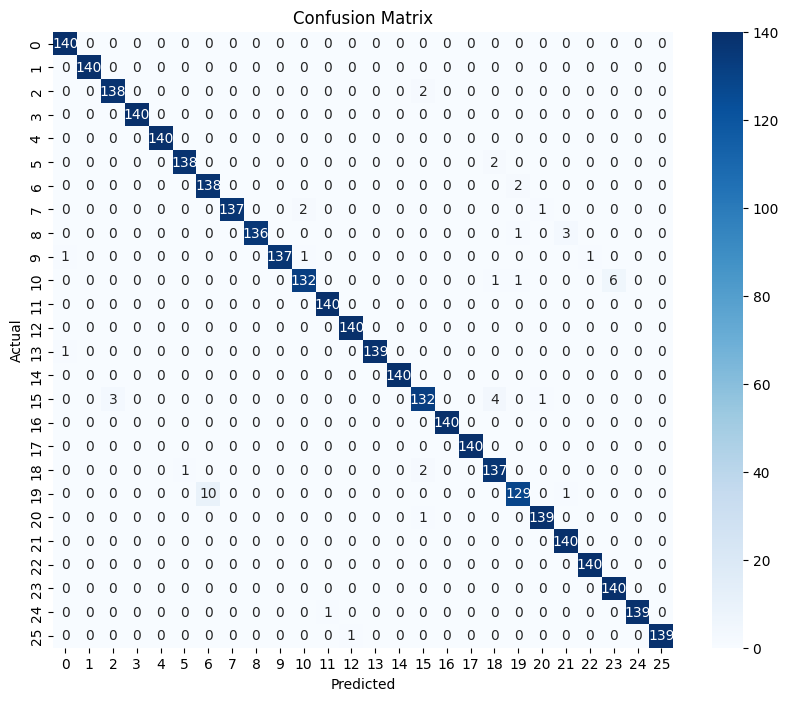

✅ SVM model saved as 'svm_model.pkl'


In [4]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load PCA features and encoded labels
X = np.load('pca_features.npy')
y = np.load('encoded_labels.npy')

# Step 2: Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Train SVM model
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = svm_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"✅ Validation Accuracy: {accuracy:.4f}")

# Step 5: Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred))

# Step 6: Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Save the model
joblib.dump(svm_model, 'svm_model.pkl')
print("✅ SVM model saved as 'svm_model.pkl'")


In [10]:
import os
import random
import numpy as np
from PIL import Image

# Parameters
DATA_FOLDER = r"D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized"
N_IMAGES = 100
IMG_SIZE = 224

def check_npy_exists(img_file, npy_folder):
    # Example: image = freshapple_0001.jpg -> npy name freshapple_0001.npy
    base_name = os.path.splitext(img_file)[0]
    npy_file = os.path.join(npy_folder, base_name + '.npy')
    return os.path.exists(npy_file)

def process_and_save_images(class_folder):
    print(f"\nProcessing class folder: {class_folder}")
    all_imgs = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    npy_folder = class_folder  # Assuming .npy files are saved in the same folder or adjust accordingly
    
    # Find leftover images: images without .npy file yet
    leftover_imgs = [img for img in all_imgs if not check_npy_exists(img, npy_folder)]

    selected_imgs = []

    if len(leftover_imgs) >= N_IMAGES:
        selected_imgs = leftover_imgs[:N_IMAGES]
        print(f"Using {N_IMAGES} leftover images.")
    elif len(leftover_imgs) == 0:
        # No leftover, take first 100 images from folder regardless of npy presence
        if len(all_imgs) >= N_IMAGES:
            selected_imgs = all_imgs[:N_IMAGES]
            print(f"No leftover images. Taking first {N_IMAGES} images from folder.")
        else:
            selected_imgs = all_imgs
            print(f"No leftover images. Folder has only {len(all_imgs)} images, taking all.")
    else:
        # Some leftover images but less than 100, fill remaining from full image set
        remaining_needed = N_IMAGES - len(leftover_imgs)
        remaining_pool = list(set(all_imgs) - set(leftover_imgs))
        random.shuffle(remaining_pool)
        selected_imgs = leftover_imgs + remaining_pool[:remaining_needed]
        print(f"Using {len(leftover_imgs)} leftover images + {len(selected_imgs) - len(leftover_imgs)} random images to reach {N_IMAGES} total.")

    print(f"Total images selected for class: {len(selected_imgs)}")

    processed_images = []
    processed_filenames = []

    for img_file in selected_imgs:
        img_path = os.path.join(class_folder, img_file)
        try:
            img = Image.open(img_path).convert('RGB')  # force 3 channels
            if img.size != (IMG_SIZE, IMG_SIZE):
                img = img.resize((IMG_SIZE, IMG_SIZE))
            img_np = np.array(img)
            processed_images.append(img_np)
            processed_filenames.append(img_file)
        except Exception as e:
            print(f"Error processing image {img_file}: {e}")

    processed_images = np.array(processed_images)
    print(f"Processed images shape: {processed_images.shape}")

    # Save all selected images to one .npy file per class
    save_path = os.path.join(class_folder, f"{os.path.basename(class_folder)}_test_images.npy")
    np.save(save_path, processed_images)
    print(f"Saved numpy array of images to {save_path}")

    # Optionally save selected filenames (for traceability)
    labels_save_path = os.path.join(class_folder, f"{os.path.basename(class_folder)}_test_filenames.npy")
    np.save(labels_save_path, np.array(processed_filenames))
    print(f"Saved filenames list to {labels_save_path}")

# Run for all subfolders (fruit classes) inside DATA_FOLDER
for class_name in os.listdir(DATA_FOLDER):
    class_path = os.path.join(DATA_FOLDER, class_name)
    if os.path.isdir(class_path):
        process_and_save_images(class_path)



Processing class folder: D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples
Using 100 leftover images.
Total images selected for class: 100
Processed images shape: (100, 224, 224, 3)
Saved numpy array of images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test_images.npy
Saved filenames list to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test_filenames.npy

Processing class folder: D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana
Using 100 leftover images.
Total images selected for class: 100
Processed images shape: (100, 224, 224, 3)
Saved numpy array of images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test_images.npy
Saved filenames list to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test_file

In [11]:
import os
import random
import numpy as np
from PIL import Image

# Parameters
DATA_FOLDER = r"D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized"
N_IMAGES = 100
IMG_SIZE = 224

def check_npy_exists(img_file, npy_folder):
    # Example: image = freshapple_0001.jpg -> npy name freshapple_0001.npy
    base_name = os.path.splitext(img_file)[0]
    npy_file = os.path.join(npy_folder, base_name + '.npy')
    return os.path.exists(npy_file)

def process_and_save_images(class_folder):
    print(f"\nProcessing class folder: {class_folder}")
    all_imgs = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    npy_folder = class_folder  # Assuming .npy files are saved in the same folder or adjust accordingly
    
    # Find leftover images: images without .npy file yet
    leftover_imgs = [img for img in all_imgs if not check_npy_exists(img, npy_folder)]

    selected_imgs = []

    if len(leftover_imgs) >= N_IMAGES:
        selected_imgs = leftover_imgs[:N_IMAGES]
        print(f"Using {N_IMAGES} leftover images.")
    elif len(leftover_imgs) == 0:
        # No leftover, take first 100 images from folder regardless of npy presence
        if len(all_imgs) >= N_IMAGES:
            selected_imgs = all_imgs[:N_IMAGES]
            print(f"No leftover images. Taking first {N_IMAGES} images from folder.")
        else:
            selected_imgs = all_imgs
            print(f"No leftover images. Folder has only {len(all_imgs)} images, taking all.")
    else:
        # Some leftover images but less than 100, fill remaining from full image set
        remaining_needed = N_IMAGES - len(leftover_imgs)
        remaining_pool = list(set(all_imgs) - set(leftover_imgs))
        random.shuffle(remaining_pool)
        selected_imgs = leftover_imgs + remaining_pool[:remaining_needed]
        print(f"Using {len(leftover_imgs)} leftover images + {len(selected_imgs) - len(leftover_imgs)} random images to reach {N_IMAGES} total.")

    print(f"Total images selected for class: {len(selected_imgs)}")

    processed_images = []
    processed_filenames = []

    for img_file in selected_imgs:
        img_path = os.path.join(class_folder, img_file)
        try:
            img = Image.open(img_path).convert('RGB')  # force 3 channels
            if img.size != (IMG_SIZE, IMG_SIZE):
                img = img.resize((IMG_SIZE, IMG_SIZE))
            img_np = np.array(img)
            processed_images.append(img_np)
            processed_filenames.append(img_file)
        except Exception as e:
            print(f"Error processing image {img_file}: {e}")

    processed_images = np.array(processed_images)
    print(f"Processed images shape: {processed_images.shape}")

    # Save all selected images to one .npy file per class
    save_path = os.path.join(class_folder, f"{os.path.basename(class_folder)}_test_images.npy")
    np.save(save_path, processed_images)
    print(f"Saved numpy array of images to {save_path}")

    # Optionally save selected filenames (for traceability)
    labels_save_path = os.path.join(class_folder, f"{os.path.basename(class_folder)}_test_filenames.npy")
    np.save(labels_save_path, np.array(processed_filenames))
    print(f"Saved filenames list to {labels_save_path}")

# Run for all subfolders (fruit classes) inside DATA_FOLDER
for class_name in os.listdir(DATA_FOLDER):
    class_path = os.path.join(DATA_FOLDER, class_name)
    if os.path.isdir(class_path):
        process_and_save_images(class_path)



Processing class folder: D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples
Using 100 leftover images.
Total images selected for class: 100
Processed images shape: (100, 224, 224, 3)
Saved numpy array of images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test_images.npy
Saved filenames list to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test_filenames.npy

Processing class folder: D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana
Using 100 leftover images.
Total images selected for class: 100
Processed images shape: (100, 224, 224, 3)
Saved numpy array of images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test_images.npy
Saved filenames list to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test_file

In [12]:
import os
import random
import numpy as np
from PIL import Image

DATA_FOLDER = r"D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized"
N_IMAGES = 100
IMG_SIZE = 224

def get_image_npy_files(folder):
    """Return two lists: image files and npy files (base names)"""
    img_files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    npy_files = [f for f in os.listdir(folder) if f.lower().endswith('.npy')]
    npy_basenames = set(os.path.splitext(f)[0] for f in npy_files)
    return img_files, npy_basenames

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    if img.size != (IMG_SIZE, IMG_SIZE):
        img = img.resize((IMG_SIZE, IMG_SIZE))
    return np.array(img)

def load_npy(npy_path):
    return np.load(npy_path)

for class_name in os.listdir(DATA_FOLDER):
    class_folder = os.path.join(DATA_FOLDER, class_name)
    if not os.path.isdir(class_folder):
        continue
    
    print(f"\nProcessing class: {class_name}")
    
    img_files, npy_basenames = get_image_npy_files(class_folder)
    
    # Images WITHOUT npy (leftover)
    leftover_imgs = [f for f in img_files if os.path.splitext(f)[0] not in npy_basenames]
    
    print(f"Leftover images (no npy): {len(leftover_imgs)}")
    print(f"Existing npy files: {len(npy_basenames)}")
    
    selected_imgs = []
    selected_npy = []
    
    if len(leftover_imgs) >= N_IMAGES:
        selected_imgs = leftover_imgs[:N_IMAGES]
        print(f"Selected {N_IMAGES} leftover images only.")
    else:
        selected_imgs = leftover_imgs
        need = N_IMAGES - len(leftover_imgs)
        # Get npy files which correspond to images (to load them later)
        npy_files_full = [os.path.join(class_folder, f + '.npy') for f in npy_basenames]
        random.shuffle(npy_files_full)
        if len(npy_files_full) >= need:
            selected_npy = npy_files_full[:need]
            print(f"Selected {len(leftover_imgs)} leftover images + {need} npy files.")
        else:
            selected_npy = npy_files_full
            print(f"Selected {len(leftover_imgs)} leftover images + {len(npy_files_full)} npy files (total less than {N_IMAGES}).")
    
    print(f"Total to process: {len(selected_imgs) + len(selected_npy)}")
    
    # Load leftover images
    images = []
    for img_file in selected_imgs:
        img_path = os.path.join(class_folder, img_file)
        try:
            img_np = load_image(img_path)
            images.append(img_np)
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
    
    # Load existing npy files
    for npy_path in selected_npy:
        try:
            npy_img = load_npy(npy_path)
            # Check if npy image shape is compatible
            if len(npy_img.shape) == 3 and npy_img.shape[0] == IMG_SIZE and npy_img.shape[1] == IMG_SIZE:
                images.append(npy_img)
            else:
                print(f"Warning: npy image {os.path.basename(npy_path)} has unexpected shape {npy_img.shape}, skipping.")
        except Exception as e:
            print(f"Error loading npy file {os.path.basename(npy_path)}: {e}")
    
    images = np.array(images)
    print(f"Final loaded images shape: {images.shape}")
    
    # Prepare labels array (all labels are this class)
    labels = np.array([class_name] * images.shape[0])
    
    # Save combined test images and labels
    save_img_path = os.path.join(class_folder, f"{class_name}_test.npy")
    save_label_path = os.path.join(class_folder, f"{class_name}_test_label.npy")
    
    np.save(save_img_path, images)
    np.save(save_label_path, labels)
    
    print(f"Saved test images to {save_img_path}")
    print(f"Saved test labels to {save_label_path}")



Processing class: freshapples
Leftover images (no npy): 936
Existing npy files: 2496
Selected 100 leftover images only.
Total to process: 100
Final loaded images shape: (100, 224, 224, 3)
Saved test images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test.npy
Saved test labels to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshapples\freshapples_test_label.npy

Processing class: freshbanana
Leftover images (no npy): 3227
Existing npy files: 7
Selected 100 leftover images only.
Total to process: 100
Final loaded images shape: (100, 224, 224, 3)
Saved test images to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test.npy
Saved test labels to D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized\freshbanana\freshbanana_test_label.npy

Processing class: freshbellpepper
Leftover images (no npy): 321
Existing npy files: 260
Selected 10

In [15]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import joblib
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Configs
DATA_FOLDER = r"D:\Data For Ecochoice Naturals\FA\Fruit_npy dataset\Fruit_Dataset_resized"
SAVED_LABEL_ENCODER = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SAVED_PCA = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
SAVED_SVM = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"
BATCH_SIZE = 32
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load saved sklearn models
label_encoder = joblib.load(SAVED_LABEL_ENCODER)
pca = joblib.load(SAVED_PCA)
svm = joblib.load(SAVED_SVM)

# Load pretrained models
def load_models():
    gn = models.googlenet(pretrained=True).to(DEVICE).eval()
    dn = models.densenet201(pretrained=True).to(DEVICE).eval()
    rx = models.resnext101_32x8d(pretrained=True).to(DEVICE).eval()

    gn.fc = torch.nn.Identity()
    dn.classifier = torch.nn.Identity()
    rx.fc = torch.nn.Identity()

    return gn, dn, rx

googlenet_model, densenet_model, resnext_model = load_models()

# Load all .npy images and labels
test_images = []
test_labels = []

for class_name in os.listdir(DATA_FOLDER):
    class_folder = os.path.join(DATA_FOLDER, class_name)
    if not os.path.isdir(class_folder):
        continue

    test_img_path = os.path.join(class_folder, f"{class_name}_test.npy")
    test_label_path = os.path.join(class_folder, f"{class_name}_test_label.npy")

    if not (os.path.exists(test_img_path) and os.path.exists(test_label_path)):
        print(f"Missing test data for class {class_name}, skipping.")
        continue

    images = np.load(test_img_path)
    labels = np.load(test_label_path)

    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)
print(f"Total test images: {test_images.shape[0]}")

# Preprocess images
processed_imgs = []
for img_np in test_images:
    if img_np.dtype != np.uint8:
        img_np = (img_np * 255).astype(np.uint8)
    img_tensor = transform(img_np)
    processed_imgs.append(img_tensor)

tensor_dataset = TensorDataset(torch.stack(processed_imgs))
dataloader = DataLoader(tensor_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Extract features batch-wise
features_all = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Extracting features"):
        imgs = batch[0].to(DEVICE)
        gn_feat = googlenet_model(imgs)
        dn_feat = densenet_model(imgs)
        rx_feat = resnext_model(imgs)

        combined = torch.cat([gn_feat, dn_feat, rx_feat], dim=1)
        features_all.append(combined.cpu())

features_combined = torch.cat(features_all, dim=0).numpy()
print(f"Feature shape: {features_combined.shape}")  # Should be (N, 4992)

# Transform labels
encoded_labels = label_encoder.transform(test_labels)

# PCA transformation
features_pca = pca.transform(features_combined)

# Predict with SVM
predicted = svm.predict(features_pca)

# Accuracy
accuracy = np.mean(predicted == encoded_labels)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


Total test images: 2483


Extracting features: 100%|██████████| 78/78 [00:50<00:00,  1.56it/s]


Feature shape: (2483, 4992)
✅ Test Accuracy: 5.72%


In [16]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import joblib
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Paths
TEST_FOLDER = r"D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\Test"
SAVED_LABEL_ENCODER = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SAVED_PCA = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
SAVED_SVM = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"

IMG_SIZE = 224
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
def load_models():
    gnet = models.googlenet(pretrained=True)
    gnet.fc = torch.nn.Identity()
    dnet = models.densenet201(pretrained=True)
    dnet.classifier = torch.nn.Identity()
    rxnet = models.resnext101_32x8d(pretrained=True)
    rxnet.fc = torch.nn.Identity()
    return gnet.to(device).eval(), dnet.to(device).eval(), rxnet.to(device).eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Get image paths and labels
image_paths = []
true_labels = []
for root, _, files in os.walk(TEST_FOLDER):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            true_labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

print(f"✅ Found {len(image_paths)} test images.")

# Load label encoder, PCA, SVM
label_encoder = joblib.load(SAVED_LABEL_ENCODER)
pca = joblib.load(SAVED_PCA)
svm = joblib.load(SAVED_SVM)

# Encode true labels
encoded_true_labels = label_encoder.transform(true_labels)

# Load pretrained models
googlenet, densenet, resnext = load_models()

# Batch-wise feature extraction
def extract_features(models, image_paths):
    features = []
    for i in tqdm(range(0, len(image_paths), BATCH_SIZE), desc="Extracting features"):
        batch_paths = image_paths[i:i+BATCH_SIZE]
        batch_tensors = []
        for path in batch_paths:
            img = Image.open(path).convert('RGB')
            img_tensor = transform(img)
            batch_tensors.append(img_tensor)
        batch_stack = torch.stack(batch_tensors).to(device)

        with torch.no_grad():
            feat_gn = models[0](batch_stack).cpu().numpy()
            feat_dn = models[1](batch_stack).cpu().numpy()
            feat_rx = models[2](batch_stack).cpu().numpy()

        combined = np.hstack([feat_gn, feat_dn, feat_rx])
        features.append(combined)
    return np.vstack(features)

# Extract features
features_combined = extract_features((googlenet, densenet, resnext), image_paths)
print(f"✅ Features extracted: {features_combined.shape}")

# PCA
features_pca = pca.transform(features_combined)

# Predict
predicted_labels = svm.predict(features_pca)

# Accuracy
accuracy = accuracy_score(encoded_true_labels, predicted_labels)
print(f"\n🎯 Test Accuracy: {accuracy * 100:.2f}%")

# Optional: Save predictions
decoded_preds = label_encoder.inverse_transform(predicted_labels)
np.save("test_predictions.npy", decoded_preds)


✅ Found 38299 test images.


c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ok\anaconda3\envs\sa\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT`

KeyboardInterrupt: 

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# Paths
TEST_FOLDER = r"d:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\Test"
SAVE_FEATURES_PATH = r"d:\Data For Ecochoice Naturals\FA\test.npy"
SAVE_LABELS_PATH = r"d:\Data For Ecochoice Naturals\FA\test_label.npy"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
MAX_IMAGES_PER_CLASS = 100

# Transformations same as training
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained models for feature extraction (without final classifier)
def load_models():
    gn = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1).to(device).eval()
    dn = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1).to(device).eval()
    rx = models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1).to(device).eval()

    gn.fc = torch.nn.Identity()
    dn.classifier = torch.nn.Identity()
    rx.fc = torch.nn.Identity()
    return gn, dn, rx

def process_and_extract_features(models, image_paths):
    gn, dn, rx = models
    features_gn, features_dn, features_rx = [], [], []

    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).unsqueeze(0).to(device)  # Add batch dim

            with torch.no_grad():
                feat_gn = gn(img_t).cpu().numpy()
                feat_dn = dn(img_t).cpu().numpy()
                feat_rx = rx(img_t).cpu().numpy()

            features_gn.append(feat_gn.squeeze())
            features_dn.append(feat_dn.squeeze())
            features_rx.append(feat_rx.squeeze())
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    feat_gn = np.array(features_gn)
    feat_dn = np.array(features_dn)
    feat_rx = np.array(features_rx)

    combined = np.hstack([feat_gn, feat_dn, feat_rx])
    return combined

all_features = []
all_labels = []

print("Loading models...")
models = load_models()

classes = sorted(os.listdir(TEST_FOLDER))
for class_name in classes:
    class_path = os.path.join(TEST_FOLDER, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    image_files = sorted(image_files)[:MAX_IMAGES_PER_CLASS]  # max 100 images per class

    image_paths = [os.path.join(class_path, f) for f in image_files]

    print(f"Processing class '{class_name}' with {len(image_paths)} images")

    features = process_and_extract_features(models, image_paths)
    all_features.append(features)
    all_labels.extend([class_name] * features.shape[0])

# Combine all classes
all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

print(f"Total features shape: {all_features.shape}")
print(f"Total labels: {len(all_labels)}")

print(f"Saving features to {SAVE_FEATURES_PATH}")
np.save(SAVE_FEATURES_PATH, all_features)

print(f"Saving labels to {SAVE_LABELS_PATH}")
np.save(SAVE_LABELS_PATH, all_labels)

print("Done.")


Loading models...
Processing class 'freshapples' with 100 images
Processing class 'freshbanana' with 100 images
Processing class 'freshbellpepper' with 100 images
Processing class 'freshbittergroud' with 100 images
Processing class 'freshcapsicum' with 100 images
Processing class 'freshcarrot' with 100 images
Processing class 'freshcucumber' with 100 images
Processing class 'freshmango' with 100 images
Processing class 'freshokra' with 100 images
Processing class 'freshorange' with 100 images
Processing class 'freshpatato' with 100 images
Processing class 'freshstrawberry' with 100 images
Processing class 'freshtomato' with 100 images
Processing class 'rottenapples' with 100 images
Processing class 'rottenbanana' with 100 images
Processing class 'rottenbellpepper' with 100 images
Processing class 'rottenbittergroud' with 100 images
Processing class 'rottencapsicum' with 100 images
Processing class 'rottencarrot' with 100 images
Processing class 'rottencucumber' with 100 images
Processi

In [4]:
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder

# Paths (make sure these match your saved model paths and test data paths)
FEATURES_PATH = r"d:\Data For Ecochoice Naturals\FA\test.npy"
LABELS_PATH = r"d:\Data For Ecochoice Naturals\FA\test_label.npy"
SAVED_LABEL_ENCODER = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SAVED_PCA = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
SAVED_SVM = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"

# Load features and labels
features = np.load(FEATURES_PATH)
labels = np.load(LABELS_PATH)

print(f"Loaded features shape: {features.shape}")
print(f"Loaded labels shape: {labels.shape}")

# Load saved models
label_encoder = joblib.load(SAVED_LABEL_ENCODER)
pca = joblib.load(SAVED_PCA)
svm = joblib.load(SAVED_SVM)

# Transform features using PCA
features_pca = pca.transform(features)

print(f"Number of features after PCA: {features_pca.shape[1]}")  # <-- This line shows features left after PCA


# Encode labels
encoded_labels = label_encoder.transform(labels)

# Predict using SVM
predictions = svm.predict(features_pca)

# Calculate accuracy
accuracy = np.mean(predictions == encoded_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Loaded features shape: (2600, 4992)
Loaded labels shape: (2600,)
Number of features after PCA: 787
Test Accuracy: 8.85%


In [5]:
print("Classes in encoder:", label_encoder.classes_)
print("Unique test labels:", np.unique(labels))


Classes in encoder: ['freshapples' 'freshbanana' 'freshbellpepper' 'freshbittergroud'
 'freshcapsicum' 'freshcarrot' 'freshcucumber' 'freshmango' 'freshokra'
 'freshorange' 'freshpatato' 'freshstrawberry' 'freshtomato'
 'rottenapples' 'rottenbanana' 'rottenbellpepper' 'rottenbittergroud'
 'rottencapsicum' 'rottencarrot' 'rottencucumber' 'rottenmango'
 'rottenokra' 'rottenoranges' 'rottenpatato' 'rottenstrawberry'
 'rottentomato']
Unique test labels: ['freshapples' 'freshbanana' 'freshbellpepper' 'freshbittergroud'
 'freshcapsicum' 'freshcarrot' 'freshcucumber' 'freshmango' 'freshokra'
 'freshorange' 'freshpatato' 'freshstrawberry' 'freshtomato'
 'rottenapples' 'rottenbanana' 'rottenbellpepper' 'rottenbittergroud'
 'rottencapsicum' 'rottencarrot' 'rottencucumber' 'rottenmango'
 'rottenokra' 'rottenoranges' 'rottenpatato' 'rottenstrawberry'
 'rottentomato']


In [6]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# CONFIG
TEST_FOLDER = r"d:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\Test"
SAVE_FEATURES_PATH = r"d:\Data For Ecochoice Naturals\FA\test.npy"
SAVE_LABELS_PATH = r"d:\Data For Ecochoice Naturals\FA\test_label.npy"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = 224
MAX_PER_CLASS = 100

# ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ----------- Dataset Definition (loads on-the-fly) ------------
class FruitDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_per_class=100):
        self.transform = transform
        self.samples = []
        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path): continue
            img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for fname in img_files[:max_per_class]:
                self.samples.append((os.path.join(class_path, fname), class_name))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Dataset and Dataloader
dataset = FruitDataset(TEST_FOLDER, transform=transform, max_per_class=MAX_PER_CLASS)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------- Load Pretrained Models -------------
def get_feature_model(base_model, layer_name):
    model = base_model
    model.eval().to(DEVICE)
    if layer_name == 'avgpool':
        return torch.nn.Sequential(*(list(model.children())[:-1]))
    elif layer_name == 'features':
        return model.features
    return model

googlenet = get_feature_model(models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1), 'avgpool')
resnext = get_feature_model(models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1), 'avgpool')
densenet = get_feature_model(models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1), 'features')

# ----------- Feature Extraction Function -----------
def extract_features(model, inputs, model_type):
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        feats = model(inputs)
        if model_type == 'densenet':
            feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1))
        return feats.view(inputs.size(0), -1).cpu()

# ----------- Feature Extraction Loop -----------
all_features = []
all_labels = []

for batch in tqdm(dataloader, desc="Extracting features"):
    x, y = batch
    f1 = extract_features(googlenet, x, 'googlenet')     # 1024
    f2 = extract_features(resnext, x, 'resnext')         # 2048
    f3 = extract_features(densenet, x, 'densenet')       # 1920
    combined = torch.cat([f1, f2, f3], dim=1)            # 4992
    all_features.append(combined)
    all_labels.extend(y)

# Save
final_features = torch.cat(all_features, dim=0).numpy()
final_labels = np.array(all_labels)

np.save(SAVE_FEATURES_PATH, final_features)
np.save(SAVE_LABELS_PATH, final_labels)
print("✅ Features shape:", final_features.shape)
print("✅ Labels shape:", final_labels.shape)


Extracting features: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]

✅ Features shape: (2600, 4992)
✅ Labels shape: (2600,)


In [7]:
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Paths
FEATURE_PATH = r"d:\Data For Ecochoice Naturals\FA\test.npy"
LABEL_PATH = r"d:\Data For Ecochoice Naturals\FA\test_label.npy"
PCA_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
ENCODER_PATH = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SVM_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"

# 1. Load test data
X_test = np.load(FEATURE_PATH)
y_test = np.load(LABEL_PATH)
print("Loaded test data:", X_test.shape, y_test.shape)

# 2. Load fitted LabelEncoder & encode labels
label_encoder = joblib.load(ENCODER_PATH)
y_test_encoded = label_encoder.transform(y_test)

# 3. Load fitted PCA and transform test features
pca = joblib.load(PCA_MODEL_PATH)
X_test_pca = pca.transform(X_test)
print("PCA transformed shape:", X_test_pca.shape)

# 4. Load trained SVM and predict
svm = joblib.load(SVM_MODEL_PATH)
y_pred = svm.predict(X_test_pca)

# 5. Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


Loaded test data: (2600, 4992) (2600,)
PCA transformed shape: (2600, 787)
✅ Test Accuracy: 95.31%


In [13]:
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Paths
FEATURE_PATH = r"d:\Data For Ecochoice Naturals\FA\test.npy"
LABEL_PATH = r"d:\Data For Ecochoice Naturals\FA\test_label.npy"
PCA_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
ENCODER_PATH = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SVM_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"

# 1. Load test data
X_test = np.load(FEATURE_PATH)
y_test = np.load(LABEL_PATH)
print("Loaded test data:", X_test.shape, y_test.shape)

# 2. Load LabelEncoder and encode labels
label_encoder = joblib.load(ENCODER_PATH)
y_test_encoded = label_encoder.transform(y_test)

# 3. Load PCA and transform features
pca = joblib.load(PCA_MODEL_PATH)
X_test_pca = pca.transform(X_test)
print("PCA transformed shape:", X_test_pca.shape)

# 4. Load trained SVM
svm = joblib.load(SVM_MODEL_PATH)

# 5. Predict labels
y_pred = svm.predict(X_test_pca)

# 6. Freshness scores using decision function
decision_scores = svm.decision_function(X_test_pca)  # shape: (N,)

# Apply sigmoid to map to [0, 100]
def sigmoid(x):
    return 100 / (1 + np.exp(-x))

freshness_scores = sigmoid(decision_scores)

# 7. Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# 8. Show predictions and freshness scores
for i in range(10):
    predicted_label = label_encoder.inverse_transform([y_pred[i]])[0]
    true_label = y_test[i]
    
    score = freshness_scores[i]
    print(freshness_scores[i])
    max_index = np.argmax(score)
    max_score = score[max_index]

    print(f"Highest freshness score: {max_score:.2f} at index {max_index}")


Loaded test data: (2600, 4992) (2600,)
PCA transformed shape: (2600, 787)
✅ Test Accuracy: 95.31%
[100.          99.9999967   99.99999956  42.32322475  93.70717719
  99.98481359  99.99947988  99.99941385  97.60856436  99.99999998
  99.99999984  99.67101771  99.99999999 100.          99.99999676
  99.99999994  66.60322587  84.47162067  99.9999967   99.99993354
  99.99997482  99.11475638  99.99922669  99.99556632  99.95533173
  99.87982277]
Highest freshness score: 100.00 at index 0
[100.          99.99466521  99.99998923  84.45683488  93.69770744
  99.99928609  99.99999108  99.98450725  97.61236778  99.99999998
  99.99999884  99.88094214  99.99999999 100.          99.99999985
  99.99999994  42.2290556   66.66056879  99.99979182  99.99999883
  99.99933873  99.10957034  99.99999629  99.99974385  99.8790134
  99.88107764]
Highest freshness score: 100.00 at index 0
[100.          99.99945225  99.99816907  66.61536049  93.6720927
  99.98504841  99.99589613  99.99997508  97.59759369  99.99999

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import joblib
import math

# Config paths - change these to your actual model paths
PCA_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\pca_model.pkl"
ENCODER_PATH = r"D:\Data For Ecochoice Naturals\FA\label_encoder.pkl"
SVM_MODEL_PATH = r"D:\Data For Ecochoice Naturals\FA\svm_model.pkl"

# Device and image parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

# ImageNet normalization transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load pretrained models and keep up to avgpool/features layer
def get_feature_model(base_model, layer_name):
    model = base_model.eval().to(DEVICE)
    if layer_name == 'avgpool':
        return torch.nn.Sequential(*(list(model.children())[:-1]))
    elif layer_name == 'features':
        return model.features
    return model

googlenet = get_feature_model(models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1), 'avgpool')
resnext = get_feature_model(models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1), 'avgpool')
densenet = get_feature_model(models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1), 'features')

def extract_features(model, inputs, model_type):
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        feats = model(inputs)
        if model_type == 'densenet':
            feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1))
        return feats.view(inputs.size(0), -1).cpu()

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def predict_image(image_path):
    # Load & preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # add batch dimension

    # Extract features from three models and concatenate
    f1 = extract_features(googlenet, image_tensor, 'googlenet')
    f2 = extract_features(resnext, image_tensor, 'resnext')
    f3 = extract_features(densenet, image_tensor, 'densenet')
    feature_vector = torch.cat([f1, f2, f3], dim=1).numpy()

    # Load PCA, Encoder, SVM models
    pca = joblib.load(PCA_MODEL_PATH)
    encoder = joblib.load(ENCODER_PATH)
    svm = joblib.load(SVM_MODEL_PATH)

    # Transform feature vector and predict label
    reduced_vector = pca.transform(feature_vector)
    y_pred = svm.predict(reduced_vector)
    pred_label = encoder.inverse_transform(y_pred)[0]

    # Extract fruit name from label
    if pred_label.startswith("fresh"):
        fruit = pred_label.replace("fresh", "").strip("_")
    elif pred_label.startswith("rotten"):
        fruit = pred_label.replace("rotten", "").strip("_")
    else:
        fruit = pred_label

    # Fix plural 'oranges' to 'orange'
    if fruit.lower() == "oranges":
        fruit = "orange"

    # Build a mapping from fruit names to class indices
    class_names = encoder.classes_
    fruit_pairs = {}
    for i, name in enumerate(class_names):
        if name.startswith("fresh"):
            fname = name.replace("fresh", "").strip("_")
            if fname == "oranges":
                fname = "orange"
            fruit_pairs.setdefault(fname, {})['fresh'] = i
        elif name.startswith("rotten"):
            fname = name.replace("rotten", "").strip("_")
            if fname == "oranges":
                fname = "orange"
            fruit_pairs.setdefault(fname, {})['rotten'] = i

    if fruit not in fruit_pairs:
        raise ValueError(f"Unknown fruit type '{fruit}' from label '{pred_label}'")

    # Get decision function scores from SVM
    decision_scores = svm.decision_function(reduced_vector)
    fresh_idx = fruit_pairs[fruit]['fresh']
    rotten_idx = fruit_pairs[fruit]['rotten']

    fresh_score = decision_scores[0][fresh_idx]
    rotten_score = decision_scores[0][rotten_idx]
    diff = fresh_score - rotten_score
    freshness_score = sigmoid(diff) * 100  # Scale to 0-100

    return pred_label, freshness_score

# Example usage for multiple images:
images = [r"D:\Data For Ecochoice Naturals\Fruits_Vegetables_Dataset(12000)\dataset\Test\freshcarrot\freshCarrot (26).jpg"]
   

for img_path in images:
    label, score = predict_image(img_path)
    print(f"Image: {os.path.basename(img_path)}")
    print(f" Predicted label: {label}")
    print(f" Freshness score: {score:.2f}/100\n")


Image: freshCarrot (26).jpg
 Predicted label: freshcarrot
 Freshness score: 73.11/100

